In [25]:
# 0) Install & Imports
# ============================================
!pip install pmdarima

from google.colab import files
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4, 4)


In [8]:
# ============================================
# 1) Upload & Read CSV
# ============================================
uploaded = files.upload()
df = pd.read_csv('World_MerchantFleet.csv')

dfw = df[df["Economy Label"] == "Saudi Arabia"].copy()

dfw["ShipType"] = (
    dfw["ShipType Label"]
      .str.strip()
      .str.lower()
      .replace({
          "total fleet": "Total fleet",
          "oil tankers": "Oil tankers",
          "bulk carriers": "Bulk carriers",
          "general cargo": "General cargo",
          "container ships": "Container ships",
          "other types of ships": "Other types of ships"
      })
)

dfw["DWT_million"] = dfw["Dead weight tons in thousands"] / 1000.0

dfw = dfw[(dfw["Year"] >= 1980) & (dfw["Year"] <= 2025)].copy()

print(dfw["Economy Label"].unique())
print(dfw["ShipType"].unique())
dfw.head()

Saving World_MerchantFleet.csv to World_MerchantFleet (1).csv
['Saudi Arabia']
['Total fleet' 'Oil tankers' 'Bulk carriers' 'General cargo'
 'Other types of ships' 'Container ships']


/tmp/ipython-input-776358453.py:5: DtypeWarning: Columns (15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('World_MerchantFleet.csv')


,Year,Economy,Economy Label,ShipType,ShipType Label,Dead weight tons in thousands,Dead weight tons in thousands Footnote,Dead weight tons in thousands Missing value,Percentage of total world,Percentage of total world Footnote,...,Number of ships,Number of ships Footnote,Number of ships Missing value,Gross Tonnage in thousands,Gross Tonnage in thousands Footnote,Gross Tonnage in thousands Missing value,Average age of vessels (years),Average age of vessels (years) Footnote,Average age of vessels (years) Missing value,DWT_million
797,1980,682,Saudi Arabia,Total fleet,Total fleet,2448.563,NaN,NaN,0.364265,NaN,...,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,2.448563
798,1980,682,Saudi Arabia,Oil tankers,Oil tankers,1982.268,NaN,NaN,0.586564,NaN,...,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,1.982268
799,1980,682,Saudi Arabia,Bulk carriers,Bulk carriers,178.026,NaN,NaN,0.097881,NaN,...,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,0.178026
800,1980,682,Saudi Arabia,General cargo,General cargo,183.689,NaN,NaN,0.162786,NaN,...,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,0.183689
801,1980,682,Saudi Arabia,Other types of ships,Other types of ships,104.580,NaN,NaN,0.357714,NaN,...,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,0.104580


In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Percentage Error
# ---------------------------------------------------------
def percent_error(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    mask = true != 0
    true = true[mask]
    pred = pred[mask]
    return np.mean(np.abs((true - pred) / true)) * 100


# ---------------------------------------------------------
# Manual ARIMA (SARIMAX)
# ---------------------------------------------------------
def manual_arima(train, test, order):

    model = sm.tsa.SARIMAX(
        train,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # TRAIN prediction (aligned)
    pred_train = model.get_prediction(
        start=train.index[0],
        end=train.index[-1]
    ).predicted_mean

    # TEST forecast (aligned)
    pred_test = model.get_forecast(steps=len(test)).predicted_mean
    pred_test.index = test.index

    # --- Handle NaNs for metric calculation ---
    # Combine actual and predicted, then drop NaNs
    combined_train = pd.DataFrame({'actual': train, 'predicted': pred_train}).dropna()
    combined_test = pd.DataFrame({'actual': test, 'predicted': pred_test}).dropna()

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(combined_train['actual'], combined_train['predicted']))
    rmse_test  = np.sqrt(mean_squared_error(combined_test['actual'],  combined_test['predicted']))

    pe_train = percent_error(combined_train['actual'].values, combined_train['predicted'].values)
    pe_test  = percent_error(combined_test['actual'].values,  combined_test['predicted'].values)

    return model, rmse_train, rmse_test, pe_train, pe_test, pred_train, pred_test


# ---------------------------------------------------------
# AUTO ARIMA GRID SEARCH (SARIMAX)
# ---------------------------------------------------------
def grid_search_arima(train, test):

    best_rmse = float("inf")
    best = None

    for p in range(0, 6):
        for d in [0, 1]:
            for q in range(0, 6):

                try:
                    model = sm.tsa.SARIMAX(
                        train,
                        order=(p, d, q),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(disp=False)

                    pred_train = model.get_prediction(
                        start=train.index[0],
                        end=train.index[-1]
                    ).predicted_mean

                    pred_test = model.get_forecast(steps=len(test)).predicted_mean
                    pred_test.index = test.index

                    # --- Handle NaNs for metric calculation ---
                    combined_train = pd.DataFrame({'actual': train, 'predicted': pred_train}).dropna()
                    combined_test = pd.DataFrame({'actual': test, 'predicted': pred_test}).dropna()

                    rmse_train = np.sqrt(mean_squared_error(combined_train['actual'], combined_train['predicted']))
                    rmse_test  = np.sqrt(mean_squared_error(combined_test['actual'], combined_test['predicted']))

                    pe_train = percent_error(combined_train['actual'].values, combined_train['predicted'].values)
                    pe_test  = percent_error(combined_test['actual'].values, combined_test['predicted'].values)

                    if rmse_test < best_rmse:
                        best_rmse = rmse_test
                        best = ((p, d, q), model,
                                rmse_train, rmse_test,
                                pe_train, pe_test,
                                pred_train, pred_test)

                except:
                    continue

    return best


# ---------------------------------------------------------
# Plotting Function
# ---------------------------------------------------------
def plot_best_model(ship, train, test, pred_train, pred_test, order):
    plt.figure(figsize=(12,5))

    # Actual
    plt.plot(train.index, train, label="Train (Actual)", linewidth=2)
    plt.plot(test.index, test, label="Test (Actual)", linewidth=2)

    # Predictions
    plt.plot(pred_train.index, pred_train, '--', label="Train Prediction")
    plt.plot(pred_test.index, pred_test, '--', label="Test Forecast")

    plt.title(f"{ship} – ARIMA {order}")
    plt.xlabel("Year")
    plt.ylabel("DWT (million)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [23]:
df_clean = dfw.copy()


In [43]:
def plot_best_model(ship, train, test, pred_train, pred_test, order):
    plt.figure(figsize=(6,4))

    plt.plot(train.index, train, label="Train (Actual)", linewidth=1)
    plt.plot(test.index, test, label="Test (Actual)", linewidth=1)

    plt.plot(pred_train.index, pred_train, '--', label="Train Prediction")
    plt.plot(pred_test.index, pred_test, '--', label="Test Forecast")

    plt.title(f"{ship} – ARIMA {order}", fontsize=8)
    plt.xlabel("Year", fontsize=7)
    plt.ylabel("DWT (million)", fontsize=7)
    plt.legend(fontsize=6)
    plt.grid(True)

    plt.show()   # ⬅️ هذا السطر لازم يكون موجود


========= Total fleet ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 0, 5)
RMSE_train: 1.2386793654664168
RMSE_test : 9.749527283864404
PE_train  : 26.833147105027972
PE_test   : 61.43620549411567

--- AUTO ARIMA: (1, 1, 4)
RMSE_train: 1.0161661447643384
RMSE_test : 6.043914801561988
PE_train  : 23.422694580840098
PE_test   : 40.55760457542422

👉 BEST MODEL = AUTO ARIMA (1, 1, 4)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 400x200 with 0 Axes>

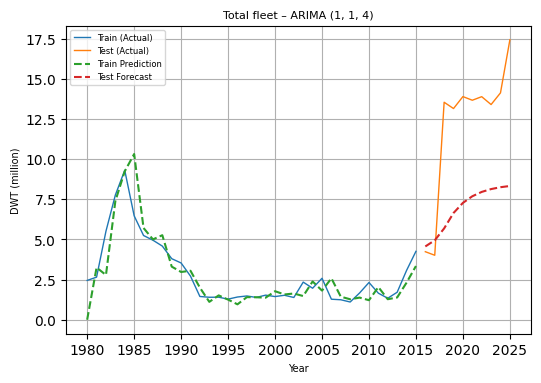

In [44]:
best_orders_dict = {}

ship = "Total fleet"

dship = df_clean[
    (df_clean["Economy Label"] == "Saudi Arabia") &
    (df_clean["ShipType"] == ship)
].sort_values("Year")

years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Total fleet ========")

# -------------------------------
# MANUAL MODEL
# -------------------------------
manual_order = (7,0,5)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 pred_train_m,
 pred_test_m) = manual_arima(train, test, manual_order)

# -------------------------------
# AUTO MODEL
# -------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 pred_train_a,
 pred_test_a) = grid_search_arima(train, test)

# -------------------------------
# SHOW RESULTS
# -------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# -------------------------------
# SELECT BEST MODEL
# -------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_model = auto_model
    best_order = auto_order
    pred_train_best = pred_train_a
    pred_test_best   = pred_test_a
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_model = manual_model
    best_order = manual_order
    pred_train_best = pred_train_m
    pred_test_best  = pred_test_m

best_orders_dict[ship] = best_order

# -------------------------------
# PLOT BEST MODEL
# -------------------------------

plt.figure(figsize=(4,2))

plot_best_model(
    ship,
    train,
    test,
    pred_train_best,
    pred_test_best,
    best_order
)

========= Oil tankers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (7, 1, 2)
RMSE_train: 1.0555596522328152
RMSE_test : 9.243631839849348
PE_train  : 46.68281524160099
PE_test   : 73.73150827784183

--- AUTO ARIMA: (2, 1, 4)
RMSE_train: 0.8278062036651348
RMSE_test : 8.502218621214196
PE_train  : 41.899202951713555
PE_test   : 66.5397639613794

👉 BEST MODEL = AUTO ARIMA (2, 1, 4)


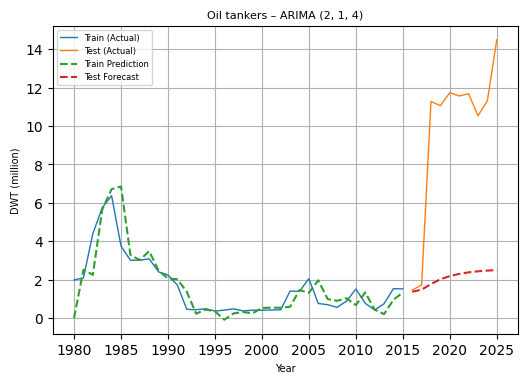

In [45]:
# =========================================================
#              RUNNING FOR ONE SHIP: OIL TANKERS
# =========================================================

ship = "Oil tankers"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split EXACTLY LIKE THE PAPER
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Oil tankers ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, (7,1,2))


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", (7,1,2))
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", (7,1,2))
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = (7,1,2)

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST MODEL
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)

========= Bulk carriers ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/st


--- MANUAL ARIMA: (6, 0, 1)
RMSE_train: 0.24715771311963086
RMSE_test : 0.5097630653655778
PE_train  : 74.47336203807157
PE_test   : 66.85013154157747

--- AUTO ARIMA: (1, 1, 3)
RMSE_train: 0.1815141501667995
RMSE_test : 0.19942013753717644
PE_train  : 161.59907685166968
PE_test   : 31.52915130406866

👉 BEST MODEL = AUTO ARIMA (1, 1, 3)


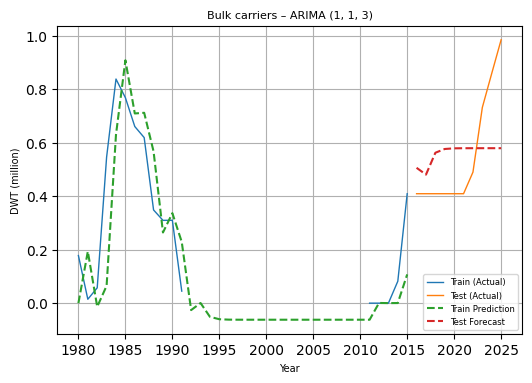

In [46]:
# =========================================================
#              RUNNING FOR ONE SHIP: BULK CARRIERS
# =========================================================

ship = "Bulk carriers"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Bulk carriers ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (6, 0, 1)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT THE BEST MODEL
# ---------------------------------------------------------
plot_best_model(ship, train, test, best_pred_train, best_pred_test, best_order)

========= General cargo ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (0, 1, 2)
RMSE_train: 0.132339471488613
RMSE_test : 0.04389156949032931
PE_train  : 18.05415240131517
PE_test   : 22.144632082093615

--- AUTO ARIMA: (0, 1, 0)
RMSE_train: 0.14116277276998745
RMSE_test : 0.009549302702291937
PE_train  : 18.107055301600536
PE_test   : 3.6401591152191792

👉 BEST MODEL = AUTO ARIMA (0, 1, 0)


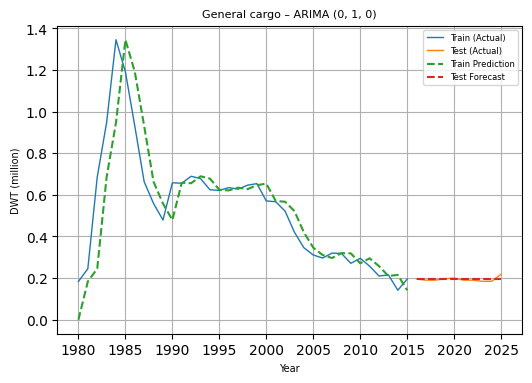

In [47]:
# =========================================================
#              RUNNING FOR ONE SHIP: GENERAL CARGO
# =========================================================

ship = "General cargo"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/test split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= General cargo ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (0,1,2)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)



# ---------------------------------------------------------
# SHOW RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# BEST MODEL SELECTION
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)


========= Container ships ========


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


--- MANUAL ARIMA: (2, 1, 3)
RMSE_train: 0.047835888268665035
RMSE_test : 0.48505999873257905
PE_train  : 24.486038949805568
PE_test   : 7157.401693133796

--- AUTO ARIMA: (0, 0, 3)
RMSE_train: 0.06851094597718663
RMSE_test : 0.059674764881919105
PE_train  : 37.63879380668505
PE_test   : 379.1846474124371

👉 BEST MODEL = AUTO ARIMA (0, 0, 3)


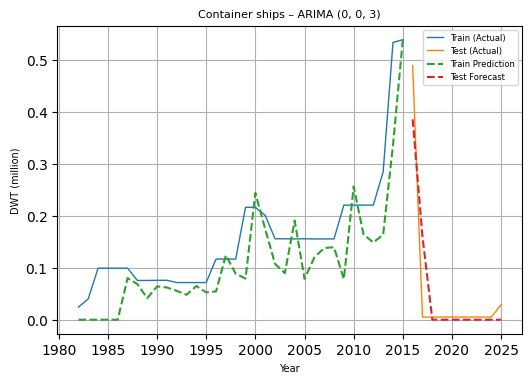

In [48]:
# =========================================================
#                RUN FOR: CONTAINER SHIPS
# =========================================================

ship = "Container ships"

# Extract series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

# Build time series
y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# Train/Test Split
train = y[y.index.year <= 2015]
test  = y[y.index.year >= 2016]

print("========= Container ships ========")

# ---------------------------------------------------------
# MANUAL ARIMA
# ---------------------------------------------------------
manual_order = (2, 1, 3)

(manual_model,
 rmse_train_m,
 rmse_test_m,
 pe_train_m,
 pe_test_m,
 manual_pred_train,
 manual_pred_test) = manual_arima(train, test, manual_order)


# ---------------------------------------------------------
# AUTO ARIMA
# ---------------------------------------------------------
(auto_order,
 auto_model,
 rmse_train_a,
 rmse_test_a,
 pe_train_a,
 pe_test_a,
 auto_pred_train,
 auto_pred_test) = grid_search_arima(train, test)


# ---------------------------------------------------------
# PRINT RESULTS
# ---------------------------------------------------------
print("\n--- MANUAL ARIMA:", manual_order)
print("RMSE_train:", rmse_train_m)
print("RMSE_test :", rmse_test_m)
print("PE_train  :", pe_train_m)
print("PE_test   :", pe_test_m)

print("\n--- AUTO ARIMA:", auto_order)
print("RMSE_train:", rmse_train_a)
print("RMSE_test :", rmse_test_a)
print("PE_train  :", pe_train_a)
print("PE_test   :", pe_test_a)


# ---------------------------------------------------------
# SELECT BEST MODEL
# ---------------------------------------------------------
if rmse_test_a < rmse_test_m:
    print("\n👉 BEST MODEL = AUTO ARIMA", auto_order)
    best_pred_train = auto_pred_train
    best_pred_test  = auto_pred_test
    best_order = auto_order
else:
    print("\n👉 BEST MODEL = MANUAL ARIMA", manual_order)
    best_pred_train = manual_pred_train
    best_pred_test  = manual_pred_test
    best_order = manual_order

best_orders_dict[ship] = best_order


# ---------------------------------------------------------
# PLOT BEST MODEL
# ---------------------------------------------------------
plot_best_model(
    ship,
    train,
    test,
    best_pred_train,
    best_pred_test,
    best_order
)

Lengths:
train1: 24  test1: 5
train2: 7  test2: 10

===== PART 1 (Before 2008) =====
RMSE_train1: 0.08650960715185231
RMSE_test1 : 0.30049671955631213
PE_train1  : 15.950830607185237
PE_test1   : 446.15662687495757

===== PART 2 (After 2008) =====
RMSE_train2: 0.2267867590361331
RMSE_test2 : 4781.4798429652765
PE_train2  : 46.38755370298141
PE_test2   : 131896.94447753413


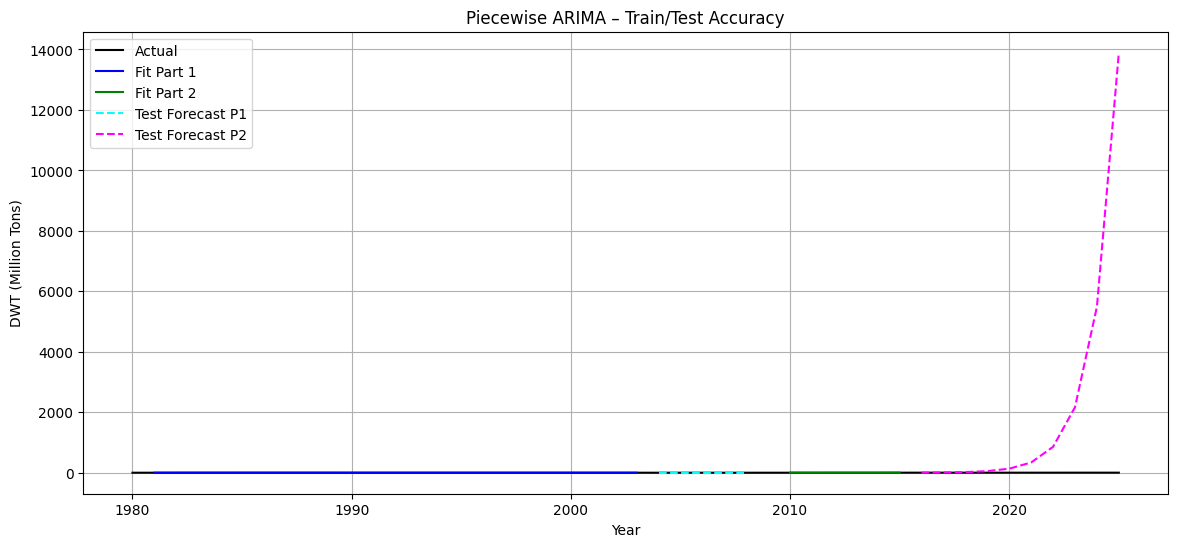

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# ============================================================
#          PIECEWISE ARIMA WITH TRAIN/TEST METRICS
# ============================================================

ship = "Other types of ships"

# Extract full time series
dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
years = dship["Year"].values

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(years, format="%Y")
).asfreq("YS")

# ============================================================
#         1) SPLIT INTO TWO REGIMES (before/after 2008)
# ============================================================

# -------- PART 1 --------
train1 = y[(y.index.year <= 2003)]
test1  = y[(y.index.year >= 2004) & (y.index.year <= 2008)]

# -------- PART 2 --------
train2 = y[(y.index.year >= 2009) & (y.index.year <= 2015)]
test2  = y[(y.index.year >= 2016)]

print("Lengths:")
print("train1:", len(train1), " test1:", len(test1))
print("train2:", len(train2), " test2:", len(test2))


# ============================================================
#         2) FIT ARIMA FOR PART 1
# ============================================================

order1 = (1,1,1)

model1 = sm.tsa.SARIMAX(
    train1, order=order1,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred_train1 = model1.predict(start=train1.index[1], end=train1.index[-1])
pred_test1  = model1.get_forecast(steps=len(test1)).predicted_mean
pred_test1.index = test1.index

RMSE_train1 = np.sqrt(mean_squared_error(train1.iloc[1:], pred_train1))
RMSE_test1  = np.sqrt(mean_squared_error(test1, pred_test1))

PE_train1 = percent_error(train1.iloc[1:].values, pred_train1.values)
PE_test1  = percent_error(test1.values, pred_test1.values)


# ============================================================
#         3) FIT ARIMA FOR PART 2
# ============================================================

order2 = (1,1,1)

model2 = sm.tsa.SARIMAX(
    train2, order=order2,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred_train2 = model2.predict(start=train2.index[1], end=train2.index[-1])
pred_test2  = model2.get_forecast(steps=len(test2)).predicted_mean
pred_test2.index = test2.index

RMSE_train2 = np.sqrt(mean_squared_error(train2.iloc[1:], pred_train2))
RMSE_test2  = np.sqrt(mean_squared_error(test2, pred_test2))

PE_train2 = percent_error(train2.iloc[1:].values, pred_train2.values)
PE_test2  = percent_error(test2.values, pred_test2.values)


# ============================================================
#         PRINT ALL RESULTS
# ============================================================

print("\n===== PART 1 (Before 2008) =====")
print("RMSE_train1:", RMSE_train1)
print("RMSE_test1 :", RMSE_test1)
print("PE_train1  :", PE_train1)
print("PE_test1   :", PE_test1)

print("\n===== PART 2 (After 2008) =====")
print("RMSE_train2:", RMSE_train2)
print("RMSE_test2 :", RMSE_test2)
print("PE_train2  :", PE_train2)
print("PE_test2   :", PE_test2)


# ============================================================
#         4) PLOT THE PIECEWISE FITS
# ============================================================

plt.figure(figsize=(14,6))

plt.plot(y.index.year, y.values, label="Actual", color="black")

plt.plot(pred_train1.index.year, pred_train1.values, label="Fit Part 1", color="blue")
plt.plot(pred_train2.index.year, pred_train2.values, label="Fit Part 2", color="green")

plt.plot(pred_test1.index.year, pred_test1.values, "--", label="Test Forecast P1", color="cyan")
plt.plot(pred_test2.index.year, pred_test2.values, "--", label="Test Forecast P2", color="magenta")

plt.title("Piecewise ARIMA – Train/Test Accuracy")
plt.xlabel("Year")
plt.ylabel("DWT (Million Tons)")
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# ============================================
#   FORECAST ALL SHIPS TO 2035 IN ONE TABLE
# ============================================

forecast_rows = []

ship_list = [
    "Total fleet",
    "Oil tankers",
    "Bulk carriers",
    "General cargo",
    "Container ships",
    "Other types of ships"
]

for ship in ship_list:

    # Extract historical clean series
    dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")
    years = dship["Year"].values

    y = pd.Series(
        dship["DWT_million"].values,
        index=pd.to_datetime(years, format="%Y")
    ).asfreq("YS")

    # Train = 1980–2015
    train = y[y.index.year <= 2015]

    # Handle 'Other types of ships' separately as it uses piecewise ARIMA
    if ship == "Other types of ships":
        # Using pred_test2 from cell Ei30wBhWLUdD, which forecasts up to 2025
        current_pred_test = pred_test2 # pred_test2 is available from previous execution

        row = {"ShipType": ship, "Best_Order": "Piecewise ARIMA"} # Indicate piecewise
        for year_forecast in range(2022, 2035 + 1):
            if year_forecast <= current_pred_test.index.year.max():
                row[f"Forecast_{year_forecast}"] = float(current_pred_test.loc[str(year_forecast)].iloc[0])
            else:
                row[f"Forecast_{year_forecast}"] = np.nan # Fill with NaN for years beyond current forecast
        forecast_rows.append(row)
        continue # Skip the rest of the loop for this ship type

    # Best ARIMA order chosen earlier
    best_order = tuple(best_orders_dict[ship])

    print(f"\n=== Forecasting {ship} using ARIMA{best_order} ===")

    # Fit the model
    model = sm.tsa.SARIMAX(
        train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast 2016 → 2035
    steps = 2035 - 2015 + 1   # = 21 steps
    forecast_all = model.get_forecast(steps=steps).predicted_mean

    # Collect only years 2022 → 2035 (or any range you want)
    row = {"ShipType": ship, "Best_Order": best_order}

    for year_forecast in range(2022, 2035 + 1):
        row[f"Forecast_{year_forecast}"] = float(forecast_all.loc[str(year_forecast)].iloc[0])

    forecast_rows.append(row)

# Final table
forecast_table_2035 = pd.DataFrame(forecast_rows)
forecast_table_2035


=== Forecasting Total fleet using ARIMA(1, 1, 4) ===

=== Forecasting Oil tankers using ARIMA(2, 1, 4) ===

=== Forecasting Bulk carriers using ARIMA(1, 1, 3) ===

=== Forecasting General cargo using ARIMA(0, 1, 0) ===

=== Forecasting Container ships using ARIMA(0, 0, 3) ===


,ShipType,Best_Order,Forecast_2022,Forecast_2023,Forecast_2024,Forecast_2025,Forecast_2026,Forecast_2027,Forecast_2028,Forecast_2029,Forecast_2030,Forecast_2031,Forecast_2032,Forecast_2033,Forecast_2034,Forecast_2035
0,Total fleet,"(1, 1, 4)",7.962482,8.139651,8.255734,8.331792,8.381626,8.414278,8.435672,8.449689,8.458873,8.464891,8.468833,8.471417,8.473109,8.474218
1,Oil tankers,"(2, 1, 4)",2.380755,2.435276,2.472842,2.498729,2.516567,2.528859,2.537329,2.543166,2.547188,2.549960,2.551869,2.553185,2.554092,2.554717
2,Bulk carriers,"(1, 1, 3)",0.579498,0.579510,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513,0.579513
3,General cargo,"(0, 1, 0)",0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192,0.195192
4,Container ships,"(0, 0, 3)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Other types of ships,Piecewise ARIMA,856.401028,2167.736314,5487.739580,13893.234198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



============= TOTAL FLEET =============


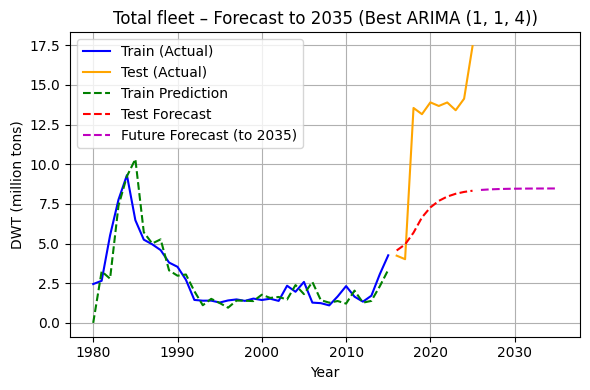


============= OIL TANKERS =============


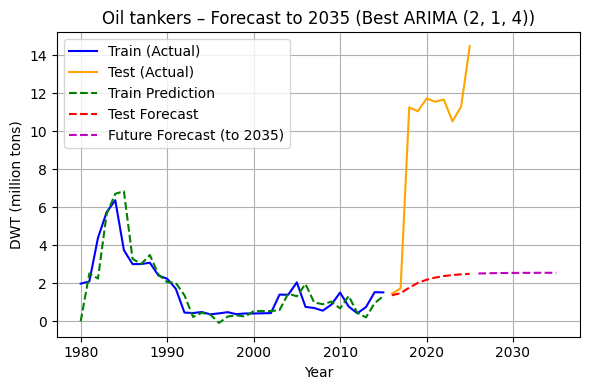


============= BULK CARRIERS =============


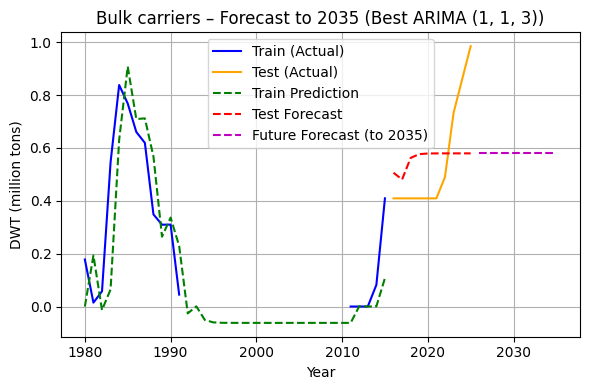


============= GENERAL CARGO =============


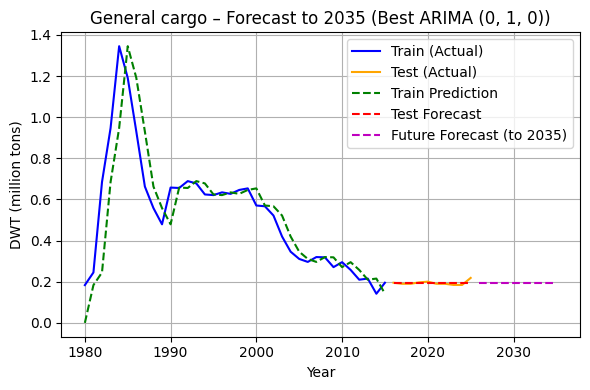


============= CONTAINER SHIPS =============


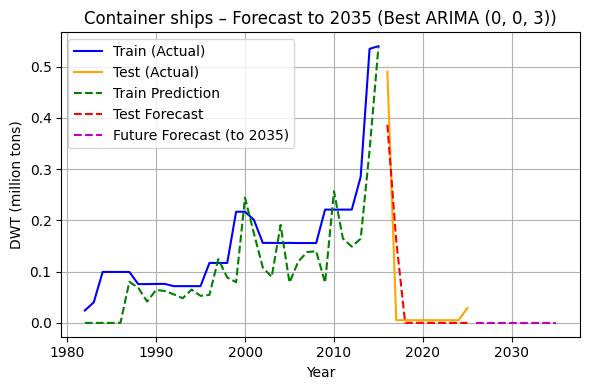


============= OTHER TYPES OF SHIPS =============
No ARIMA model found for Other types of ships. Skipping.


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
#          AUTO-PLOT BEST MODEL FOR ALL 6 SHIP TYPES
# ============================================================

ship_list = [
    "Total fleet",
    "Oil tankers",
    "Bulk carriers",
    "General cargo",
    "Container ships",
    "Other types of ships"
]

for ship in ship_list:

    print(f"\n============= {ship.upper()} =============")

    # Extract time series
    dship = df_clean[df_clean["ShipType"] == ship].sort_values("Year")

    if dship.empty:
        print(f"No data found for {ship}. Skipping.")
        continue

    years = dship["Year"].values

    y = pd.Series(
        dship["DWT_million"].values,
        index=pd.to_datetime(years, format="%Y")
    ).asfreq("YS")

    # Train/test split
    train = y[y.index.year <= 2015]
    test = y[y.index.year >= 2016]

    # Ensure best order exists
    if ship not in best_orders_dict:
        print(f"No ARIMA model found for {ship}. Skipping.")
        continue

    best_order = best_orders_dict[ship]

    # Fit on TRAIN
    model = sm.tsa.SARIMAX(
        train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # ============================
    #  FORECAST from 2016 → 2035
    # ============================

    forecast_start_year = 2016
    forecast_end_year = 2035
    total_forecast_years = forecast_end_year - forecast_start_year + 1

    forecast_res = model.get_forecast(steps=total_forecast_years)

    fc_mean = forecast_res.predicted_mean

    # Fix forecast index
    forecast_index = pd.date_range(start="2016", periods=total_forecast_years, freq="YS")
    fc_mean.index = forecast_index

    # Split into test and future
    fc_test = fc_mean.iloc[:len(test)]
    fc_future = fc_mean.iloc[len(test):]

    # TRAIN prediction
    pred_train = model.predict(start=train.index[0], end=train.index[-1])

    # ==============================
    #             PLOT
    # ==============================
    plt.figure(figsize=(6, 4))

    # --- Actual Data ---
    plt.plot(train.index.year, train.values, label="Train (Actual)", color="blue")
    if not test.empty:
        plt.plot(test.index.year, test.values, label="Test (Actual)", color="orange")

    # --- Train Prediction ---
    plt.plot(pred_train.index.year, pred_train.values, "--", label="Train Prediction", color="green")

    # --- Test Forecast ---
    if not test.empty:
        plt.plot(test.index.year, fc_test.values, "r--", label="Test Forecast")

    # --- Future Forecast (2016–2035) ---
    plt.plot(fc_future.index.year, fc_future.values, "m--", label="Future Forecast (to 2035)")

    plt.title(f"{ship} – Forecast to 2035 (Best ARIMA {best_order})")
    plt.xlabel("Year")
    plt.ylabel("DWT (million tons)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
df_clean["Year"].unique()
